In [1]:
import pickle

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [2]:
import sys
sys.path.insert(0, "../")
from utils import directed_er_generator, team_maker, clique_adder

# Overview

We are constructing a directed graph in which team labels are determined by the attributes of a specific member within each team. The graph creation process involves several steps. Initially, we generate the desired number of nodes using the Erdos Renyi model. Subsequently, we associate each node in the network with a corresponding team. As the next step, we establish an internal structure for each team by introducing edges that form a clique among its nodes.

In the final stage, we augment the nodes with attributes that enable the differentiation of teams based on the attribute of a single node within each team. The remaining members within the team share identical attributes across all nodes in the graph. Our objective is to create a dataset with three distinct labels, thus resulting in four node types:

- *Pro*: This designation is given to a specific user exhibiting **high** levels of skill.
- *Good*: This category pertains to a particular user displaying **intermediate** levels of skill.
- *Mediocre*: Within this classification falls a specific user possessing **limited** skills.
- *Noob*: This classification encompasses common users characterized by **basic** skills.

In [3]:
# Define node attributes data.
data = {"name": ["pro", "good", "mediocre", "noob"],
        "ability": [81.0, 74.0, 68.0, 45.0],
        "communication": [2, 3, 3, 2],
        "leadership": [89, 76, 68, 48],
        "coldness": [77.0, 74.0, 63.0, 51.0],
        "knowledge": [72, 54, 52, 29],
        "reputation": [3, 1, 1, 1],
        "creativity": [65.0, 63.0, 60.0, 32.0],
        "label": [2, 1, 0, -1]}

attributes = pd.DataFrame(data)
attributes

,name,ability,communication,leadership,coldness,knowledge,reputation,creativity,label
0,pro,81.0,2,89,77.0,72,3,65.0,2
1,good,74.0,3,76,74.0,54,1,63.0,1
2,mediocre,68.0,3,68,63.0,52,1,60.0,0
3,noob,45.0,2,48,51.0,29,1,32.0,-1


In [4]:
# Create random directed graph.
G = directed_er_generator(n = 10000)

In [5]:
# Remove self-loop.
G.remove_edges_from(nx.selfloop_edges(G))

In [6]:
# Assign each node to a team (no overlapping) and get team composition: {team_id: [node_1, node_2, ...]}.
G, teams_composition = team_maker(G)

In [7]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of teams: {len(teams_composition)}")

Number of nodes: 10008
Number of teams: 990


In [8]:
# Add clique structure to each team.
G = clique_adder(G, teams_composition)

In [9]:
np.random.seed(0)

teams_composition = pd.DataFrame(teams_composition.items(), columns = ["team", "members"])
# Create 3 random classes across the teams.
teams_composition["label"] = np.random.randint(0, 3, teams_composition.shape[0])
teams_composition.head()

,team,members,label
0,0,"[9065, 836, 3726, 4500, 8681, 6220, 377, 651, ...",0
1,1,"[6047, 610, 9150, 8119, 4726, 7978, 8563, 7699...",1
2,2,"[3558, 8074, 3740, 9298, 4902, 1022, 378, 8853...",0
3,3,"[540, 5354, 158, 8206, 9029, 9108, 8888, 6219,...",1
4,4,"[821, 6590, 406, 8427, 9801, 5498, 7261, 5795]",1


In [10]:
# Classes distribution.
teams_composition["label"].value_counts()

label
0    335
1    332
2    323
Name: count, dtype: int64

In [11]:
# Create dictionary team labels.
teams_label = teams_composition.set_index("team")["label"].to_dict()

In [12]:
# Random select one member for each team that will be discriminate the team label.
np.random.seed(0)

teams_composition["member_discriminative"] = teams_composition["members"].apply(lambda x: np.random.choice(x, 1)[0])
teams_composition.head()

,team,members,label,member_discriminative
0,0,"[9065, 836, 3726, 4500, 8681, 6220, 377, 651, ...",0,915
1,1,"[6047, 610, 9150, 8119, 4726, 7978, 8563, 7699...",1,7978
2,2,"[3558, 8074, 3740, 9298, 4902, 1022, 378, 8853...",0,3558
3,3,"[540, 5354, 158, 8206, 9029, 9108, 8888, 6219,...",1,8206
4,4,"[821, 6590, 406, 8427, 9801, 5498, 7261, 5795]",1,8427


In [13]:
# Assign attributes to nodes.
nodes_attribute = teams_composition.explode("members")
nodes_attribute.loc[~(nodes_attribute["members"] == nodes_attribute["member_discriminative"]), "label"] = -1
nodes_attribute = pd.merge(nodes_attribute, attributes, on = "label", how = "left")
nodes_attribute.drop(["member_discriminative", "label"], axis = 1, inplace = True)
nodes_attribute = nodes_attribute.sort_values("members").set_index(["members", "team"])
nodes_attribute.index.names = ("node", "team")
# Make each name unique adding a suffix.
nodes_attribute["name"] = nodes_attribute.groupby("name")["name"].transform(lambda x: x + "_" + np.arange(len(x)).astype(str))
nodes_attribute.head()

,,name,ability,communication,leadership,coldness,knowledge,reputation,creativity
node,team,,,,,,,,
0,252,noob_0,45.0,2,48,51.0,29,1,32.0
1,446,noob_1,45.0,2,48,51.0,29,1,32.0
2,12,noob_2,45.0,2,48,51.0,29,1,32.0
3,394,noob_3,45.0,2,48,51.0,29,1,32.0
4,217,noob_4,45.0,2,48,51.0,29,1,32.0


In [14]:
# Create node name dictionary: {node_id: "name"}.
nodes_name = nodes_attribute["name"].droplevel("team", axis = 0).to_dict()
# Create team composition dictionary: {node_id: [team_id]}.
teams_composition = nodes_attribute.groupby("node").apply(lambda x: list(x.index.get_level_values("team")))

In [15]:
nodes_attribute.drop("name", axis = 1, inplace = True)

In [16]:
# Add team attribute to each node.
nx.set_node_attributes(G, teams_composition, "Team")  

In [17]:
# Save networkx graph.
with open("./data/graph.pkl", "wb") as f:
    pickle.dump(nx.readwrite.json_graph.node_link_data(G), f)

# Save teams label.
with open("./data/teams_label.pkl", "wb") as out:
    pickle.dump(teams_label, out)

# Save node attributes.
with open("./data/nodes_attribute.pkl", "wb") as f:
    pickle.dump(nodes_attribute, f)
    
# Save node names.
with open("./data/nodes_name.pkl", "wb") as out:
    pickle.dump(nodes_name, out)

# Visualization

Let's reproduce the previous graph in a smaller scale.

In [18]:
np.random.seed(23)

# Create random directed graph.
G = directed_er_generator(n = 30)
G.remove_edges_from(nx.selfloop_edges(G))
G, teams_composition = team_maker(G, min_team_size = 4, poisson_mean = 3)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of teams: {len(teams_composition)}")

# Add clique structure to each team.
G = clique_adder(G, teams_composition)

df = pd.DataFrame(teams_composition.items(), columns = ["team", "members"])
df["label"] = np.random.randint(0, 3, df.shape[0])
df["member_discriminative"] = df["members"].apply(lambda x: np.random.choice(x, 1)[0])
df.head()

Number of nodes: 30
Number of teams: 5


,team,members,label,member_discriminative
0,0,"[22, 20, 16, 10, 21, 28, 15, 11, 2]",0,16
1,1,"[27, 17, 23, 26, 25, 13, 12]",1,25
2,2,"[19, 24, 9, 14, 18]",0,19
3,3,"[29, 1, 6, 3, 0]",1,29
4,4,"[8, 4, 5, 7]",1,8


In [19]:
# Assign attributes to nodes.
nodes_attribute = df.explode("members")
nodes_attribute.loc[~(nodes_attribute["members"] == nodes_attribute["member_discriminative"]), "label"] = -1
nodes_attribute = pd.merge(nodes_attribute, attributes, on = "label", how = "left")
nodes_attribute = nodes_attribute.sort_values("members").set_index(["members", "team"])
nodes_attribute.index.names = ("node", "team")
nodes_attribute.head()

,,label,member_discriminative,name,ability,communication,leadership,coldness,knowledge,reputation,creativity
node,team,,,,,,,,,,
0,3,-1,29,noob,45.0,2,48,51.0,29,1,32.0
1,3,-1,29,noob,45.0,2,48,51.0,29,1,32.0
2,0,-1,16,noob,45.0,2,48,51.0,29,1,32.0
3,3,-1,29,noob,45.0,2,48,51.0,29,1,32.0
4,4,-1,8,noob,45.0,2,48,51.0,29,1,32.0


In [20]:
node_teams = nodes_attribute.reset_index("team")["team"].to_dict()
node_names = nodes_attribute.reset_index("team")["name"].to_dict()
node_labels = nodes_attribute.reset_index("team")["label"].to_dict()
node_colors = [sns.color_palette("pastel")[v] for k,v in node_teams.items()]

In [21]:
# Add team and name attributes to each node.
nx.set_node_attributes(G, node_teams, "Team")  
nx.set_node_attributes(G, node_names, "Name")  

In [22]:
noob = [k for k,v in node_names.items() if v == "noob"]
mediocre = [k for k,v in node_names.items() if v == "mediocre"]
good = [k for k,v in node_names.items() if v == "good"]
pro = [k for k,v in node_names.items() if v == "pro"]

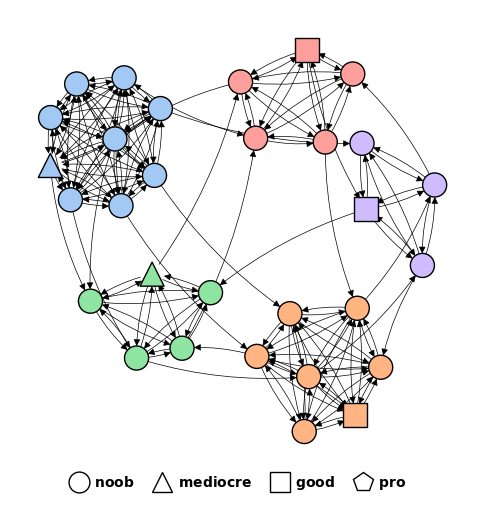

In [23]:
fig, ax = plt.subplots(figsize = (6, 6)) 
ax.axis("off")

pos = nx.layout.kamada_kawai_layout(G)

nx.draw_networkx_edges(G, pos, width = 0.5, arrowsize = 10, connectionstyle = "arc3, rad = 0.1", ax = ax)
nodes = nx.draw_networkx_nodes(G, pos, nodelist = noob, node_color = [node_colors[n] for n in noob], linewidths = 1., 
                               node_size = 300, node_shape = "o", ax = ax)
nodes.set_edgecolor("k") # node border
nodes = nx.draw_networkx_nodes(G, pos, nodelist = mediocre, node_color = [node_colors[n] for n in mediocre], linewidths = 1., 
                               node_size = 300, node_shape = "^", ax = ax)
nodes.set_edgecolor("k") # node border
nodes = nx.draw_networkx_nodes(G, pos, nodelist = good, node_color = [node_colors[n] for n in good], linewidths = 1., 
                               node_size = 300, node_shape = "s", ax = ax)
nodes.set_edgecolor("k") # node border
nodes = nx.draw_networkx_nodes(G, pos, nodelist = pro, node_color = [node_colors[n] for n in pro], linewidths = 1., 
                               node_size = 300, node_shape = "p", ax = ax)
nodes.set_edgecolor("k") # node border

legend_elements = [Line2D([0], [0], marker = "o", color = "k", label = r" $\bf{noob}$", markerfacecolor = "w", markersize = 15),
                   Line2D([0], [0], marker = "^", color = "k", label = r" $\bf{mediocre}$", markerfacecolor = "w", markersize = 15),
                   Line2D([0], [0], marker = "s", color = "k", label = r" $\bf{good}$", markerfacecolor = "w", markersize = 15),
                   Line2D([0], [0], marker = "p", color = "k", label = r" $\bf{pro}$", markerfacecolor = "w", markersize = 15)]
leg = ax.legend(handles = legend_elements, loc = "lower center", bbox_to_anchor = (0.5, -0.07), 
                ncol = 4, frameon = False, fancybox = True, numpoints = 1, handlelength = 0)

fig.savefig("./data/attributes.png", bbox_inches = "tight", dpi = 300)